# Cluster Analysis: Partitioning (Segmentation)

Create a set of functions that can be used together to segment satellite images into similar regions using k-means clustering, and then create and apply a color mask to areas of water. Specifically:

1. Determine the best image pre-processing method that will do the best job of smoothing similar colors
    - sub-regions in satellite images tend to have a lot of color variation / texture that can negatively impact the performance of segmentation when using something like k-means clustering
    - use scikit-image for this
2. Create a pre_process funcition that returns a pre-processed version of the image that has the following parameters
    - img : the input image
    - p : whatever parameter belongs to the method you chose from (1)
    - multichannel : Bool for whether or not the image has multiple channels (e.g. RGB)
        + only if necessary
3. Create one or more functions that together are used for segmenting an image using k-means clustering
4. Create a function to help automate the selection of parameters to use in the method from (1) and for k-means 
    - it should iterate over a set of 6 possible test parameter combinations
        + each combination is (pre-processing parameter, n_clusters for kmeans)
    - each iteration should segment the provided satellite image using the the given combination
    - return a single image that displays the segmented versions in a 3x2 grid
    - visually inspect the 6 versions and decide on the best combination to use
5. Use the parameters determined above to create a version of the original image that has a single-colored mask wherever water appears in the image

## 1. Determine the best image pre-processing method that will do the best job of smoothing similar colors
- sub-regions in sattelite images tend to have a lot of color variation / texture that can negatively impact the performance of segmentation when using something like k-means clustering
- use scikit-image for this

First let's import a few essentials and look at our satellite image.

In [12]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter

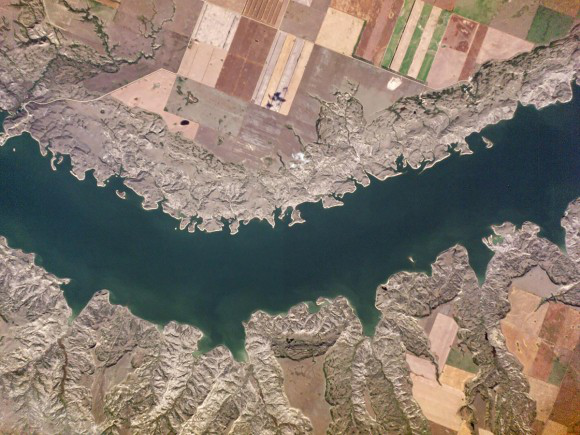

In [2]:
img0 = Image.open('Segmentation/sat4.jpg')
img0

There is a lot of texture in the areas around the river, and just a bit in the cultivated land areas. Two easy options worth exploring for reducing the texture are gaussian blur (a well known image filter) and de-noising. While there are many methods of smoothing images, some are only suited to greyscale images. These two for sure work with multi-channel (color) images, so we will try them out.

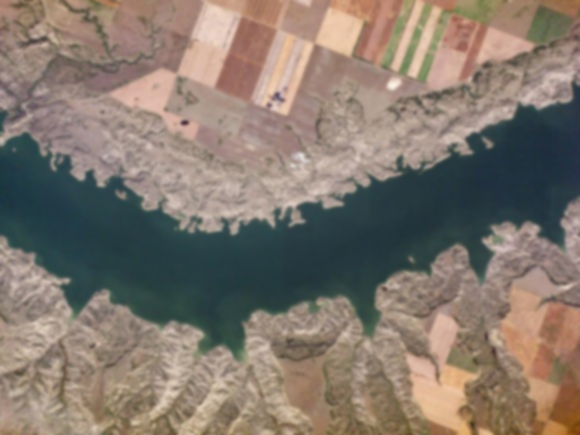

In [3]:
from skimage.filters import gaussian
# apply the filter (returns an array)
# sigma is parameter for the blur (higher value => more blur)
img1 = gaussian(np.array(img0), sigma=1.5, multichannel=True)
# multiply result by 255 for rgb (current values in range [0,1])
img1 = 255*img1
# convert back to image and show it
img1 = Image.fromarray(img1.astype('uint8'))  # uint8 for image format
img1

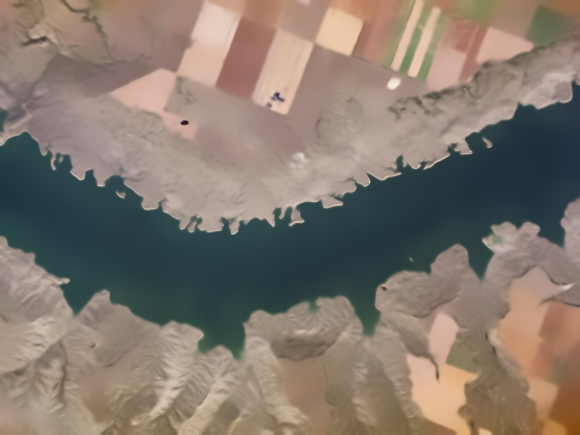

In [4]:
from skimage.restoration import denoise_nl_means as dnm
# apply
# h is a parameter that determines how smooth the image is (higher h => more smooth)
img2 = dnm(np.array(img0), h=25, multichannel=True)
img2 = Image.fromarray(img2.astype('uint8'))
img2

Obviously gaussian blur is insufficient for our needs, because it doesn't preserve the edges within the photo and too much blur would be required to get smoothed colors. The best option is to de-noise the image, leaving edges relatively intact. The only downside is how long the de-noising takes.

## 2. Create a pre_process funcition that returns a pre-processed version of the image that has the following parameters
- img : the input image
- p : whatever parameter belongs to the method you chose from (1)
- multichannel : Bool for whether or not the image has multiple channels (e.g. RGB)
    + only if necessary

This is a pretty simple function that requires only three lines, not including the return.

In [5]:
def pre_process(img, h, multichannel):
    from skimage.restoration import denoise_nl_means as dnm
    
    img2 = dnm(np.array(img), h=h, multichannel=multichannel)
    # convert array to image
    img2 = Image.fromarray(img2.astype('uint8'))
    
    return img2

**Test it**

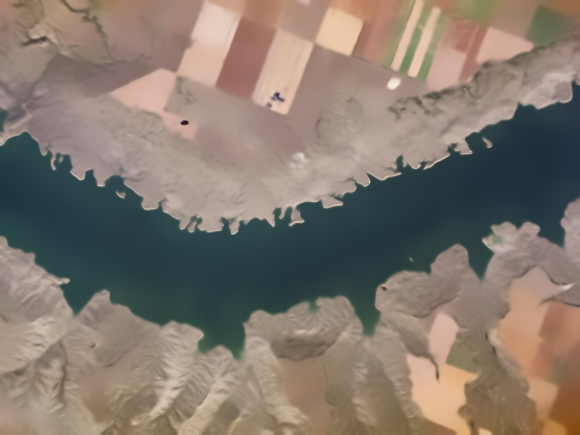

In [6]:
pre_process(img0, 25, True)

## 3. Create one or more functions that together are used for segmenting an image using k-means clustering

Segmenting will require some colors to apply. We can either manually create an array of RGB values, or just use some that are already pre-defined:
* You can find color scheme names [here](https://matplotlib.org/examples/color/colormaps_reference.html).

For ease of maintenance and comprehension let's split this process into two functions:
* `image_labels()` : perform the cluster analysis and return a list of labels along with the (mostly) flattened image
* `segment_image()` : use the results from `image_labels()` to segment the image and return the result

In [7]:
def image_labels(img, n_clusters):
    from sklearn.cluster import KMeans as KM
    
    # set seed for consistency in cluster labels
    #  for demonstraion purposes only
    np.random.seed(1234)
    
    # flatten image for clustering (one vector per channel (r,g,b))
    flat_img = np.array(img).reshape(-1,3)
    
    # create and fit k-means on img and get labels
    km = KM(n_clusters).fit(flat_img)
    labels = km.labels_
    
    # scikit-image slic clustering
#     from skimage.segmentation import slic
#     slic_labels = slic(img1, n_segments=5, sigma=1.5, enforce_connectivity=False)
    
    return flat_img, labels

In [8]:
def segment_image(img, flat_img, labels, cmap):
    import seaborn as sns
    # create array of colors to use in segmentation
    colors = sns.color_palette(cmap, len(np.unique(labels)))
    colors = [255*np.array(c) for c in colors]
    
    # assign colors based on labels
    seg_img = flat_img.copy()
    for i,c in enumerate(labels):
        seg_img[i] = colors[c]
    
    # reshape img_seg array and convert to image
    seg_img = Image.fromarray(seg_img.reshape(np.array(img).shape))
    
    # we will need the colors for masking
    return seg_img, colors

**Let's test them all together**

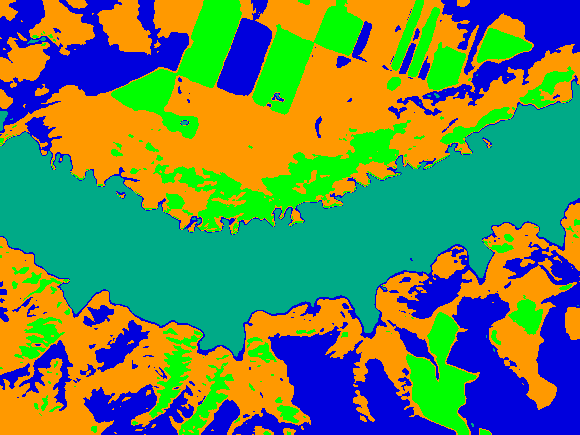

In [9]:
pre = pre_process(img0, 25, True)
flat, labels = image_labels(pre, 4)
result, _ = segment_image(pre, flat, labels, 'spectral')
result

## 4. Create a function to help automate the selection of parameters to use in the method from (1) and for k-means 
- it should iterate over a set of 6 possible test parameter combinations
    + each combination is (pre-processing parameter, n_clusters for kmeans)
- each iteration should segment the provided satellite image using the the given combination
- return a single image that displays the segmented versions in a 3x2 grid
- visually inspect the 6 versions and decide on the best combination to use

For the 6 possible parameters we can have a grid parameter that takes in an array of combinations to iterate over. We will use itertools to create that grid before running the function.

In [10]:
def image_variations(img, grid):
    
    # init list to store image variations
    image_vars = []
    
    # vectors of h- and k-vals
    # k := number of clusters
    h = grid[:, 0]
    k = grid[:, 1]
    
    # only need to handle 6 variations
    for i in range(6):
        pre_img = pre_process(img, h[i], True)
        flat_img, labels = image_labels(pre_img, k[i])
        seg_img, _ = segment_image(pre_img, flat_img, labels, 'spectral')
        
        # store image
        image_vars.append(np.array(seg_img))
        
    # create single array of images
    stack1 = np.hstack([image_vars[0], image_vars[1]])
    stack2 = np.hstack([image_vars[2], image_vars[3]])
    stack3 = np.hstack([image_vars[4], image_vars[5]])
    image_arr = np.vstack([stack1, stack2, stack3])
    
    # convert to image
    image_arr = Image.fromarray(image_arr)
    
    return image_arr

In [11]:
from itertools import product

# use itertools product method to create all possible combination from two lists
# first list is of the pre-processing param values we want to test
# second list is of the numer of clusters we want to test
grid = np.array(list(product([25, 30],[3, 4, 5])))

grid.reshape(3,4)  # same layout as image array

array([[25,  3, 25,  4],
       [25,  5, 30,  3],
       [30,  4, 30,  5]])

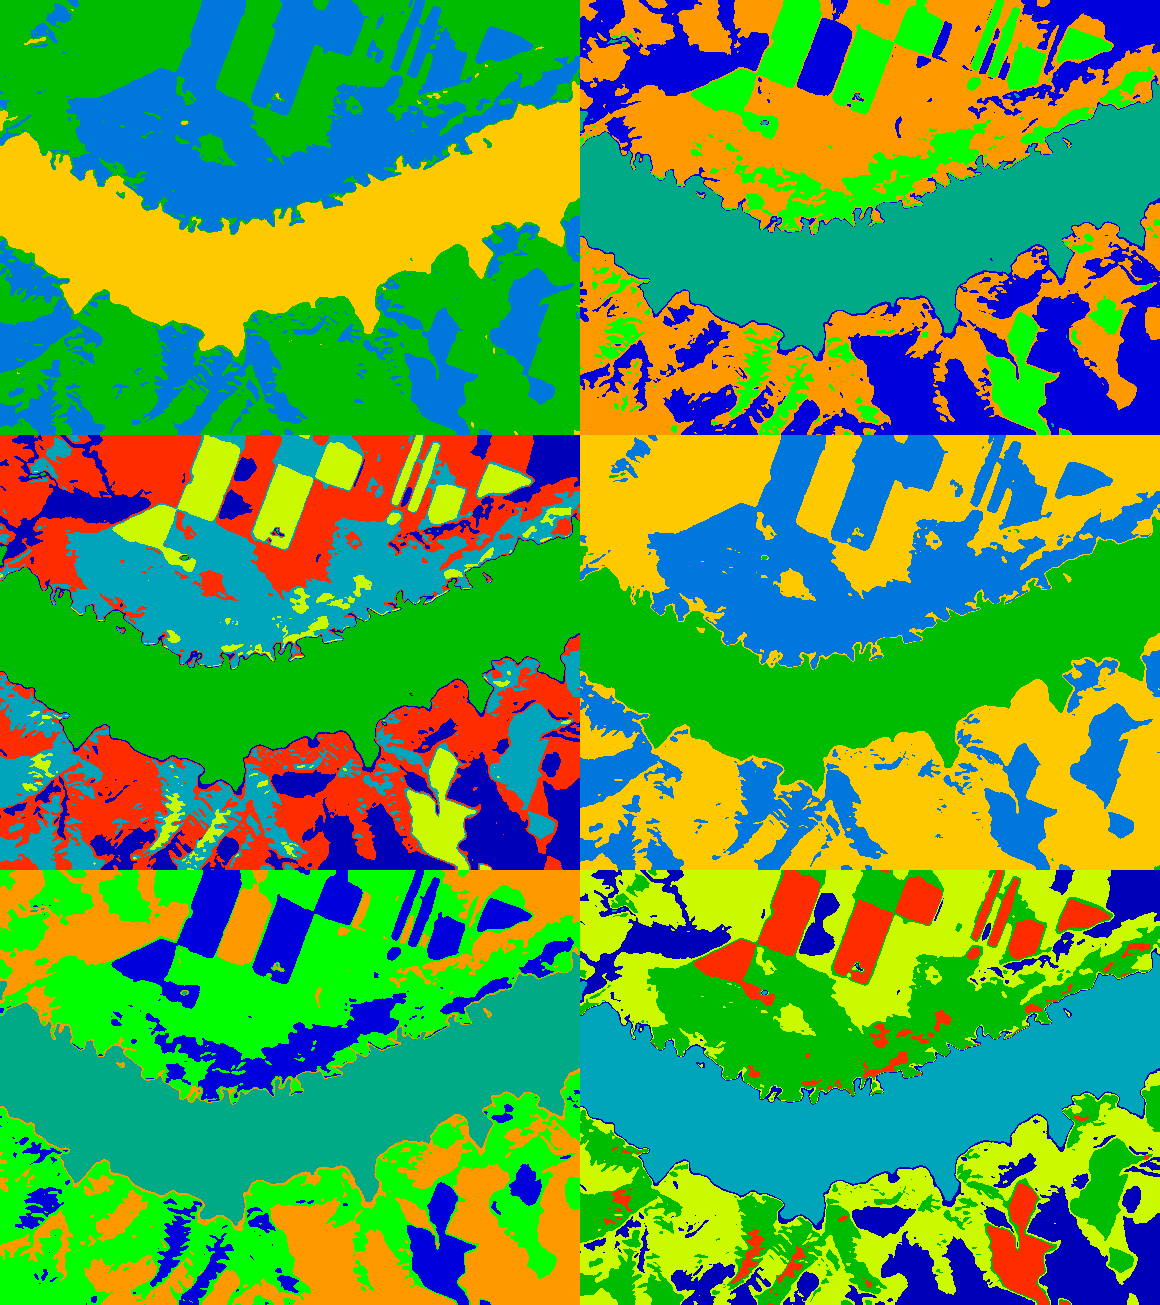

In [12]:
img_arr = image_variations(img0, grid)
img_arr

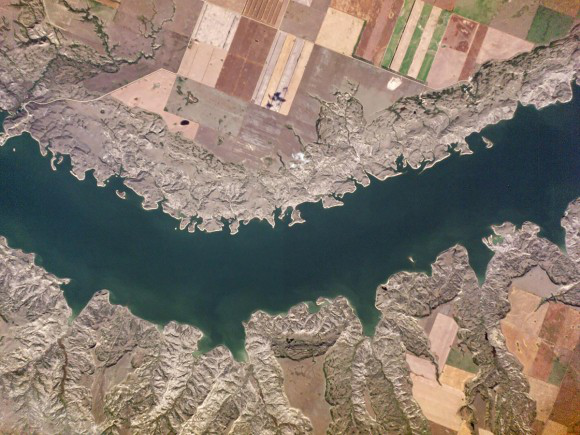

In [13]:
# original for comparison
img0

* The top left is almost ideal, because it preserves enough detail in the river boundaries, especially the little island, but it tends to also label fom shadows in the rocky areas as water.
* Middle right is also pretty decent, but it losees the smaller island in th water (too much smoothing). 
* Upper right is almost there, but again, some of the shadows in the rocks on th top-right of the river are labeled as water.
* Middle left seems like the right balance of detail while minimizing labeling shadows as water.
    - the values here are (h=25, k=5)

## 5. Use the parameters determined above to create a version of the original image that has a single-colored mask wherever water appears in the image

First we need to reproduce this version and look at the color values to determine how to segment the water (this is why our function returns colors)

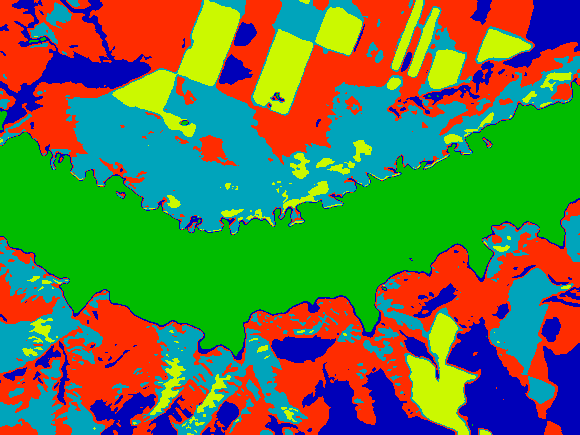

In [14]:
pre_img = pre_process(img0, 25, True)
flat_img, labels = image_labels(pre_img, 5)
seg_img, colors = segment_image(pre_img, flat_img, labels, 'spectral')
seg_img

In [15]:
colors

[array([   0.    ,    0.    ,  185.0085]),
 array([   0.    ,  164.339 ,  187.0085]),
 array([   0.    ,  188.3255,    0.    ]),
 array([ 203.9915,  249.3305,    0.    ]),
 array([ 255.,   45.,    0.])]

The river is green, thus the third array (in RGB order) &mdash; which is index=2 &mdash; is the one being applied. This means class label 2 corresponds to water.

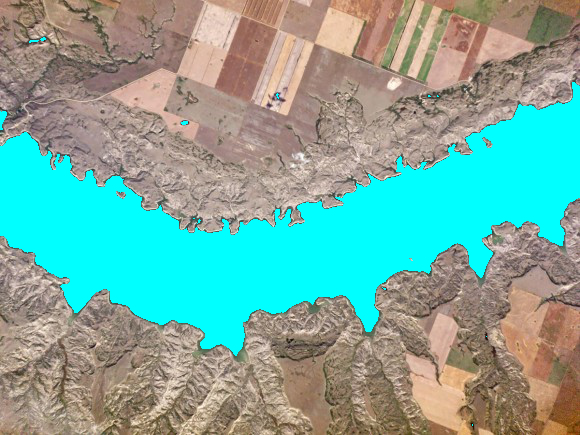

In [16]:
# modify the color assigned to lower left pixel (guaranteed to be water)
# the river is the green color, which corresponds to the third row in the array [r, g, b] order
water_label = 2
colors[water_label] = [0, 255, 255]

# assign colors based on labels
img1_seg = np.array(img0).reshape(-1,3)
for i,c in enumerate(labels):
    # apply only if water
    if c == water_label:
        img1_seg[i] = colors[c]

img1_seg = Image.fromarray(img1_seg.reshape(np.array(img1).shape))
img1_seg

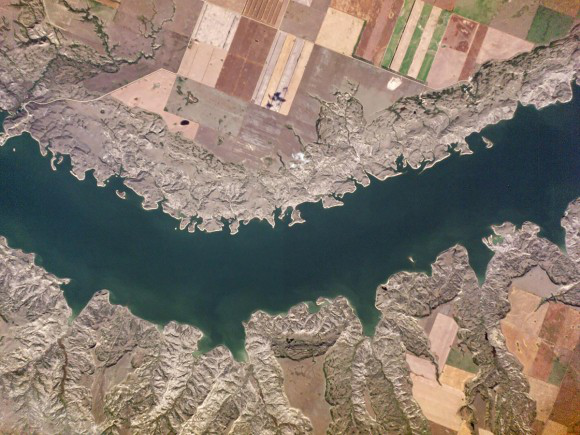

In [17]:
img0

# Cluster Analysis: Target Study (Young People Survey) using agglomerative clustering

The dataset provided can be summarized as follows:

In 2013, students of the Statistics class at FSEV UK were asked to invite their friends to participate in this survey.

* The data file (responses.csv) consists of 1010 rows and 150 columns (139 integer and 11 categorical).
* For convenience, the original variable names were shortened in the data file. See the columns.csv file if you want to match the data with the original names.
* The data contain missing values.
* The survey was presented to participants in both electronic and written form.
* The original questionnaire was in Slovak language and was later translated into English.
* All participants were of Slovakian nationality, aged between 15-30.
* Numerical columns are primarily in range [1,5], except for values like weight and height.

Your task is to use agglomerative (hierarchical) cluster analysis to analyze this data. Specifically:

1. Modify the original data
    - Remove any categorical variables from the data
        - categorical doesn't work with this clustering method
        - we aren't concerned with creating dummy vars
    - Add a new column for gender, but make it binary
    - Remove any rows with null values
2. Use scipy to cluster and create a dendrogram of the cluster hierarchy for the data
    - use the ward method
    - exclude gender for now
    - plot the dendrogram
    - determine a good cutoff value
    - re-plot the dendrogram with a line for the cutoff and determine the number of clusters this gives
3. Create a new dendrogram that truncates using the determined number of clusters and show number of points per cluster
    - hint: check the truncate_mode options
4. Use the scipy `hierarchy.fcluster` method to get cluster labels for 16 clusters from the data
    - hint: threshold
    - create a column for the labels in the data
    - compare the class distributions between genders
    - reset the threshold and create a new set of labels that will give only two classes
        - add this as a second column for labels
    - compare the distributions of these two classes between genders
        - does it seem that the two top-level clusters are gender-specific?

In [4]:
# read data
import pandas as pd
from pandas import DataFrame as DF, Series

data = pd.read_csv('../Targeted/responses.csv')

In [5]:
data.dtypes.value_counts()

float64    134
object      11
int64        5
dtype: int64

## 1. Modify the original data
- Remove any categorical variables from the data
    - categorical doesn't work with this clustering method
    - we aren't concerned with creating dummy vars
- Add a new column for gender, but make it binary
- Remove any rows with null values

In [6]:
data_num = data.select_dtypes(exclude=[object]).copy()
data_num['gender'] = data.Gender.map({'female': 1, 'male': 0})
data_num.shape

(1010, 140)

In [7]:
data_num.dropna(how='any', inplace=True)
data_num.shape

(684, 140)

## 2. Use scipy to cluster and create a dendrogram of the data hierarchy
- use the ward method
- exclude gender for now
- plot the dendrogram
- determine a good cutoff value
- re-plot the dendrogram with a line for the cutoff and determine the number of clusters this gives

In [8]:
from scipy.cluster.hierarchy import dendrogram, linkage

# this is what we need for the dendrogram
z = linkage(data_num.drop('gender', axis=1), 'ward')

a given row of `z` gives us `[idx_a, idx_b, d, count]`, where 

* `idx_a` and `idx_b` : the indexes for the two records in our data that were merged in that step
* `d` : the distance between these data points
* `count` : the number of samples in the cluster just created

In [9]:
z.shape

(683, 4)

In [10]:
z[:, -1].max()

684.0

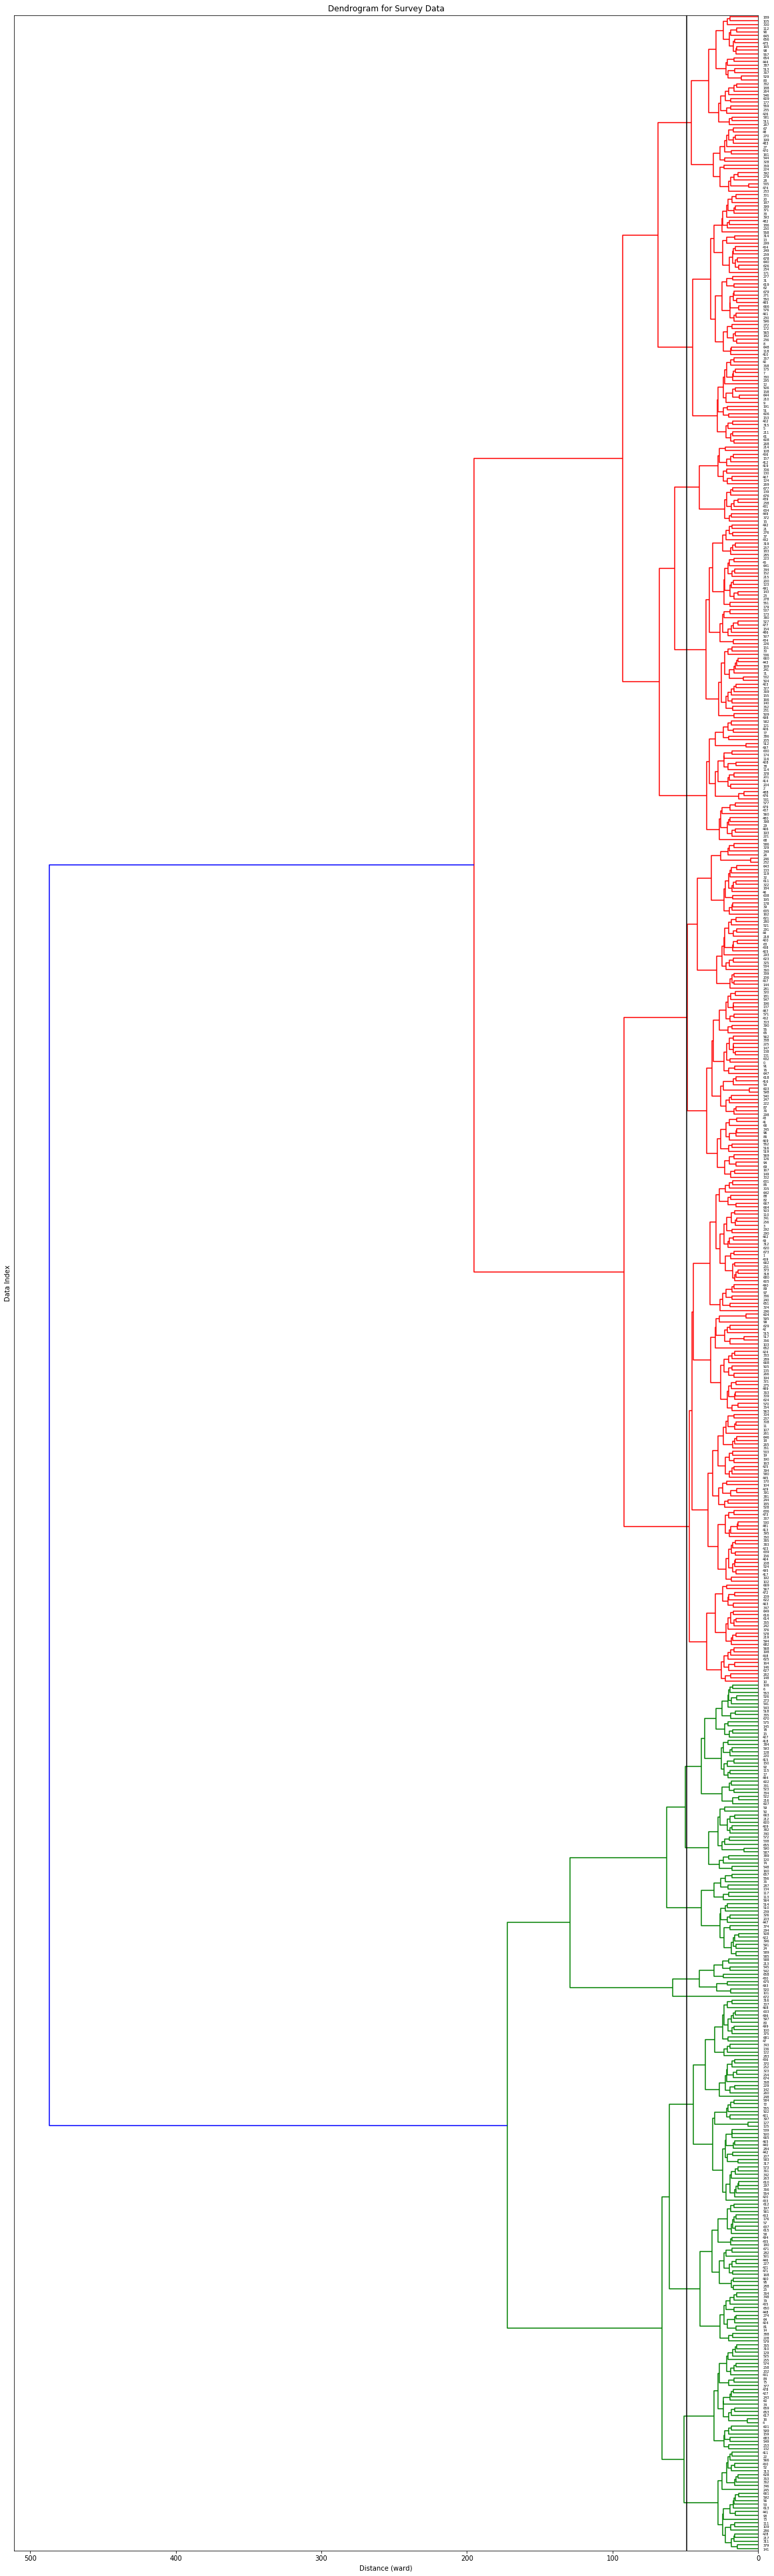

In [13]:
plt.figure(figsize=(20,70))
plt.title('Dendrogram for Survey Data')
plt.xlabel('Distance (ward)')
plt.ylabel('Data Index')
dendrogram(z, orientation='left', leaf_rotation=0)
# plot cutoff line at distance = 49
plt.axvline(49, color='k');

Counting the number of lines that intersect the cutoff, there are 16 clusters.

## 3. Create a new dendrogram that truncates using the determined number of clusters and show number of points per cluster
- hint: check the truncate_mode options

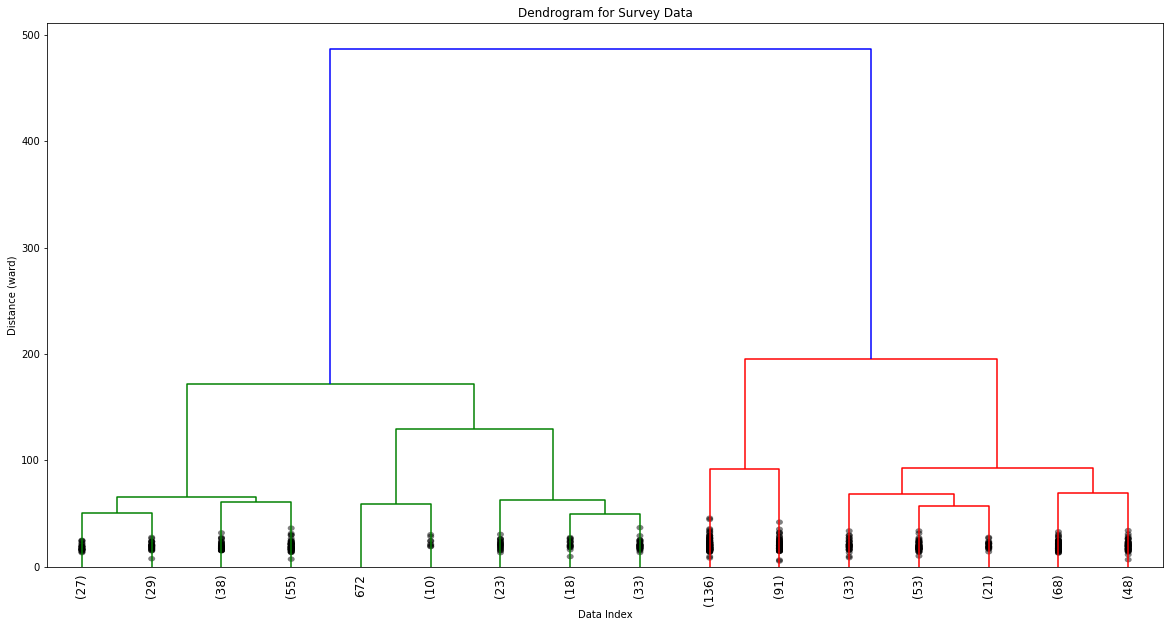

In [14]:
plt.figure(figsize=(20,10))
plt.title('Dendrogram for Survey Data')
plt.xlabel('Data Index')
plt.ylabel('Distance (ward)')
# p is the number of clusters
# lastp is telling the algorithm to truncate using the number of clusters we set
dendrogram(z, orientation='top', leaf_rotation=90, p=16, truncate_mode='lastp', show_contracted=True);

* Number in () on x-axis indicate number of data points in that group
* Lack of parentheses indicate a single item, and the number is the index in the data

## 4. Use the scipy `hierarchy.fcluster` method to get cluster labels for 16 clusters from the data
- hint: threshold
- create a column for the labels in the data
- compare the class distributions between genders
- reset the threshold and create a new set of labels that will give only two classes
    - add this as a second column for labels
- compare the distributions of these two classes between genders
    - does it seem that the two top-level clusters are gender-specific?

In [15]:
from scipy.cluster.hierarchy import fcluster
# we get cluster labels by using the linkage array (z) that we created earlier
# t=49 is setting the threshold that we determined before (this will give desired number of clusters)
clusters = fcluster(Z=z, t=49, criterion='distance')
clusters.max()

16

There are class labels that are aligned with the rows in our data. Let's add a cluster column

In [16]:
data_num['cluster'] = clusters

### Inspect gender differences

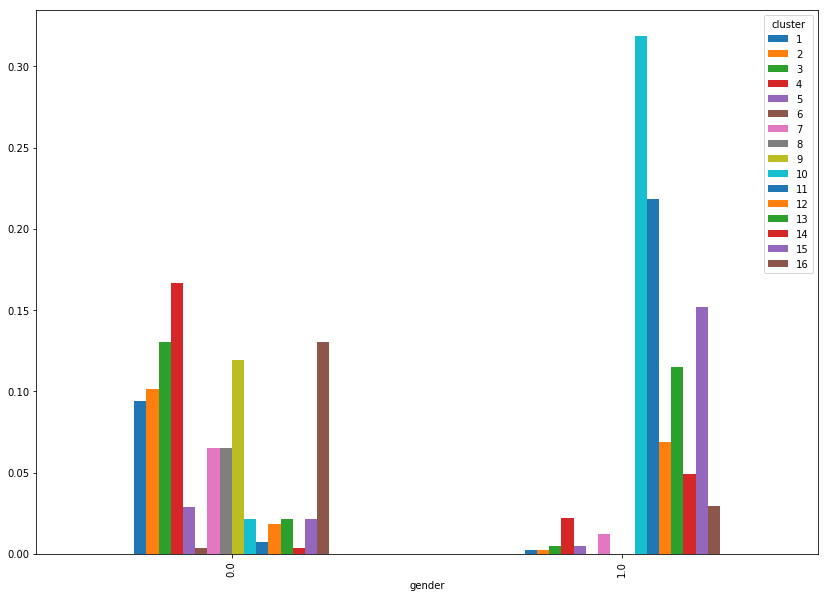

In [17]:
# user groupby to get gender-specific counts for each class
g = data_num.groupby(['gender', 'cluster']).size().unstack()
# compute proportions of classes by gender
gp = g.div(g.sum(axis=1), axis=0)

gp.plot.bar(figsize=(14,10));

Interestingly, there appear to be very disticnt differences between men and women. This could be partially due to height/weigth differences.

### Reset the threshold and create a new set of labels that will give only two classes

In [18]:
clusters2 = fcluster(Z=z, t=250, criterion='distance')

In [19]:
data_num['cluster2'] = clusters2

In [20]:
data_num.groupby(['cluster2', 'gender']).size()

cluster2  gender
1         0.0       214
          1.0        20
2         0.0        62
          1.0       388
dtype: int64

They two top-level classes most definitely are gender-speific. No need to do a significance test here.

# Data Summarization / Color Quantization

Given a set of images, use k-means to perform color quantization to reduce the number of distinct colors in each image. Specifically

1. Create a quantize function that takes an image and the desired number of colors as parameters and
    - performs color quantization using k-means
        - reduce the number of colors in the image
    - return the color-reduced image
    - make sure it can handle both greyscale and multichannel images
    - run this function on the image titled bw.jpg and view the result
2. Create a batch_reduce function that takes a list of file names and number of desired colors as parameters and
    - imports/opens each image in the list of file names
    - uses the quantize function to reduce the number of colors in each image
    - saves the original and reduced images in separate folders
3. Run the batch_reduce on everything in the provided images folder and then compare original and reduced file sizes

## 1. Create a quantize function that takes an image and the desired number of colors as parameters and
- performs color quantization using k-means
    - reduce the number of colors in the image
- return the color-reduced image
- run this function on the image titled bw.jpg and view the result

In [33]:
def quantize(img, n_colors):
    from sklearn.cluster import KMeans as KM
    
    # set seed for consistency in cluster labels
    #  for demonstraion purposes only
    np.random.seed(1234)
    
    shape = np.array(img).shape
    if (len(shape) == 3):
        # flatten image for clustering (one vector per channel (r,g,b))
        flat_img = np.array(img).reshape(-1,3)
    else:
        # image is greyscale
        flat_img = np.array(img).reshape(-1,1)
    
    # create and fit k-means on img
    km = KM(n_colors).fit(flat_img)
    # get labels and cluster centers
    labels = km.labels_
    centers = km.cluster_centers_
    
    # color quantize using cluster centers
    quant_img = flat_img.copy()
    for i,c in enumerate(labels):
        quant_img[i] = centers[c]
        
    quant_img = Image.fromarray(quant_img.reshape(shape))
    return quant_img

In [34]:
bw = Image.open('Quantization/bw.jpg')

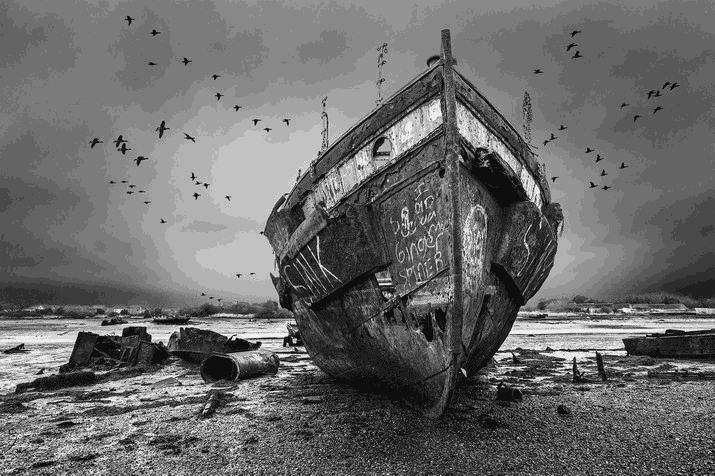

In [35]:
bw_q = quantize(bw, 16)
bw_q

## 2. Create a batch_reduce function that takes a list of file names and number of desired colors as parameters and
- imports/opens each image in the list of file names
- uses the quantize function to reduce the number of colors in each image
- saves the original and reduced images in separate folders

In [49]:
def batch_reduce(files, n_colors):
    import os
    
    reduced = []
    images = []
    
    # read images
    for f in files:
        img = Image.open(f)
        images.append(img)
    
    # quantize images
    for img in images:
        im_q = quantize(img, n_colors)
        reduced.append(im_q)
    print('Images quantized')
        
    # save reduced as png
    root = 'Quantization/images/reduced/'
    if not os.path.exists(root):
        os.makedirs(root)
    
    for i, im in enumerate(reduced):
        im.save(root + 'im_q_{}.png'.format(i))
    
    # save originals as png
    root = 'Quantization/images/original/'
    if not os.path.exists(root):
        os.makedirs(root)
        
    for i, im in enumerate(images):
        im.save(root + 'im_{}.png'.format(i)) 
    print('Images saved')

## 3. Run the batch_reduce on everything in the provided images folder and then compare original and reduced file sizes

In [43]:
import os
os.listdir('Quantization/images')

['grayscale.jpg', 'coffee.jpg', 'bw.jpg', 'flowers.jpg']

In [48]:
import os
images = os.listdir('Quantization/images')
files = ['Quantization/images/'+f for f in images]
batch_reduce(files, 16)

Images quantized
Images saved


Check these new files and notice that the reduced images are each roughly half the file size of the originals. The reduced and original files will be in the same location as this notebook.

# Clustering with PCA and Machine Learning

Create a simple custom pipeline that does the following with the survey data:

- train/test split using 67% of the data for the train
- perform PCA and select the number of components that retain at least 90% of the variance
- perform k-means clustering on the PCA training set (scki-kit learn) with 16 clusters
- apply the cluster labels to the training set
- fit the labeled training set using a Random Forest Classifier
- make predictions on the test set using both the k-means and rfc models
- compare the two model predictions using class-wise precision, recall, and f1

In [21]:
data = data_num.drop(['cluster', 'cluster2'], axis=1)

# train/test split
Xtr = data.sample(frac=0.67)
Xts = data[~data.index.isin(Xtr.index)].values
Xtr = Xtr.values

# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=None).fit(Xtr)
components = pca.components_
ex_var = pca.explained_variance_ratio_
# select components
sums = ex_var.cumsum()
n_comps = 0
for i, s in enumerate(sums):
    if s > 0.9:
        n_comps = i
        break
# transform train and test sets
pca = PCA(n_components=n_comps).fit(Xtr)
Xtr = pca.transform(Xtr)
Xts = pca.transform(Xts)

# k-means
from sklearn.cluster import KMeans as KM
from sklearn.ensemble import RandomForestClassifier as RF

# just for consistency
np.random.seed(123)

km = KM(n_clusters=16).fit(Xtr)
labels = km.predict(Xtr)

# train RF classifier
rf = RF(n_estimators=500).fit(Xtr, labels)

# make predictions with RF and Cluster and compare
y_rf = rf.predict(Xts)
y_km = km.predict(Xts)

from sklearn.metrics import classification_report as crp

report = crp(y_km, y_rf)
print(report)

             precision    recall  f1-score   support

          0       0.90      0.82      0.86        11
          1       0.60      0.43      0.50         7
          2       0.60      0.38      0.46         8
          3       0.67      0.96      0.79        25
          4       0.00      0.00      0.00         5
          5       1.00      0.30      0.46        10
          6       0.75      0.19      0.30        16
          7       0.68      0.92      0.78        25
          8       0.52      0.88      0.65        16
          9       0.65      0.94      0.77        18
         10       0.80      0.84      0.82        19
         11       0.75      0.50      0.60         6
         12       0.68      0.85      0.75        27
         13       1.00      0.20      0.33        15
         14       0.00      0.00      0.00         5
         15       0.80      0.92      0.86        13

avg / total       0.70      0.69      0.64       226



C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


There will be a message for UndefinedMetricWarning above--this is fine.
So the two don't entirely agree, but they aren't bad for so little data.

In [22]:
n_comps

55